# 1 Getting Setup

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
from pathlib import Path
import shutil
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import random
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import random_split

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import gradio as gr
except:
    !pip install gradio
    import gradio as gr
    
    
    



device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Functions To Train Models Later

In [5]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y_pred)
    return train_loss / len(dataloader), train_acc / len(dataloader)

def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y_pred)
    return test_loss / len(dataloader), test_acc / len(dataloader)

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, 
          loss_fn: torch.nn.Module, epochs: int, device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")
    return results

# 2 Effnetb2 Model

## 2.1
Make a Function To Make Model And Freeze All Trainable Parameters Except Classifier Head

In [6]:
def create_effnetb2(num_classes: int = 101):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  for params in model.parameters():
    params.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model,transforms

effnetb2,effnetb2_transforms = create_effnetb2(num_classes=101)
effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 132MB/s] 


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
summary(effnetb2, input_size=(1, 3, 224, 224),col_names=['input_size','output_size','num_params','trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 2.2
Get The Data And Make A Data Loaders For Effnetb2 Model

In [9]:
# First We Will Make Data Augmentation Transform for Training Data To Eliminate Overfitting
train_transforms_effnetb2 = torchvision.transforms.Compose([ torchvision.transforms.TrivialAugmentWide(),
                                             effnetb2_transforms])
# We Will Load Food101 Dataset Using Pytorch
train_data_effnetb2 = torchvision.datasets.Food101(root="data", # Passing Root Directory
                             split='train', # Passing Train Split
                             transform=train_transforms_effnetb2, # Passing Train Transform
                             download=True)


test_data_effnetb2 = torchvision.datasets.Food101(root="data", # Passing Root Directory
                             split='test', # Passing Test Split
                             transform=effnetb2_transforms, # Passing Test Normal Transform
                             download=True)

100%|██████████| 4996278331/4996278331 [02:17<00:00, 36208078.26it/s]


Extracting data/food-101.tar.gz to data


In [10]:
# Print First 10 Classes Names
class_names = train_data_effnetb2.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Create a function to use only a part of the dataset
# We will train the model on only 20% of the data to reduce computational costs
def split_dataset(dataset,split_size:float=.2):
  length_1 = int(len(dataset)*split_size)
  length_2 = int(len(dataset)-length_1)

  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2])
  return random_split_1, random_split_2

train_data_effnetb2_20_percent,_ = split_dataset(dataset=train_data_effnetb2,split_size=.2)
test_data_effnetb2_20_percent,_ = split_dataset(dataset=test_data_effnetb2,split_size=.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


In [12]:
# Create The Data Loader
batch_size = 32 # We Will Keep Constant Batch Size 32 In The Whole Notebook
num_workers=os.cpu_count() # Num Workers Equal Two

train_dataloader_effnetb2_20_percent = torch.utils.data.DataLoader(dataset=train_data_effnetb2_20_percent,
                                                                   batch_size=batch_size,
                                                                   shuffle=True,
                                                                   num_workers=num_workers
                                                                   )


test_dataloader_effnetb2_20_percent = torch.utils.data.DataLoader(dataset=test_data_effnetb2_20_percent,
                                                                 batch_size=batch_size,
                                                                 shuffle=False,
                                                                 num_workers=num_workers)

## 2.3 Train Effnetb2 Model



In [15]:
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # Label Smoothing Is Regularization To Reduce Overfitting
optimizer = torch.optim.Adam(params=effnetb2.parameters(),lr=0.001)

effnetb2_results = train(model=effnetb2,train_dataloader=train_dataloader_effnetb2_20_percent,test_dataloader=test_dataloader_effnetb2_20_percent,optimizer=optimizer,loss_fn=loss,device=device,epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: train_loss=2.9639, train_acc=0.4183, test_loss=2.4764, test_acc=0.5420
Epoch 2: train_loss=2.6445, train_acc=0.4873, test_loss=2.3277, test_acc=0.5689
Epoch 3: train_loss=2.5048, train_acc=0.5212, test_loss=2.2783, test_acc=0.5790
Epoch 4: train_loss=2.4402, train_acc=0.5401, test_loss=2.2451, test_acc=0.5822
Epoch 5: train_loss=2.3888, train_acc=0.5483, test_loss=2.2383, test_acc=0.5863
Epoch 6: train_loss=2.3317, train_acc=0.5712, test_loss=2.2187, test_acc=0.5951
Epoch 7: train_loss=2.3121, train_acc=0.5747, test_loss=2.2085, test_acc=0.5968
Epoch 8: train_loss=2.2786, train_acc=0.5792, test_loss=2.2117, test_acc=0.5952
Epoch 9: train_loss=2.2478, train_acc=0.5974, test_loss=2.1991, test_acc=0.5960
Epoch 10: train_loss=2.2444, train_acc=0.5941, test_loss=2.1884, test_acc=0.6010


The model achieves an accuracy of aprox 0.6, which may seem low at first glance. However, it's important to note that the model is classifying among 101 different classes, which presents a significant challenge in accuracy evaluation knowing that the basline accuracy it 0.01(random classification accuracy)

## 2.4 Evaluate Effnetb2

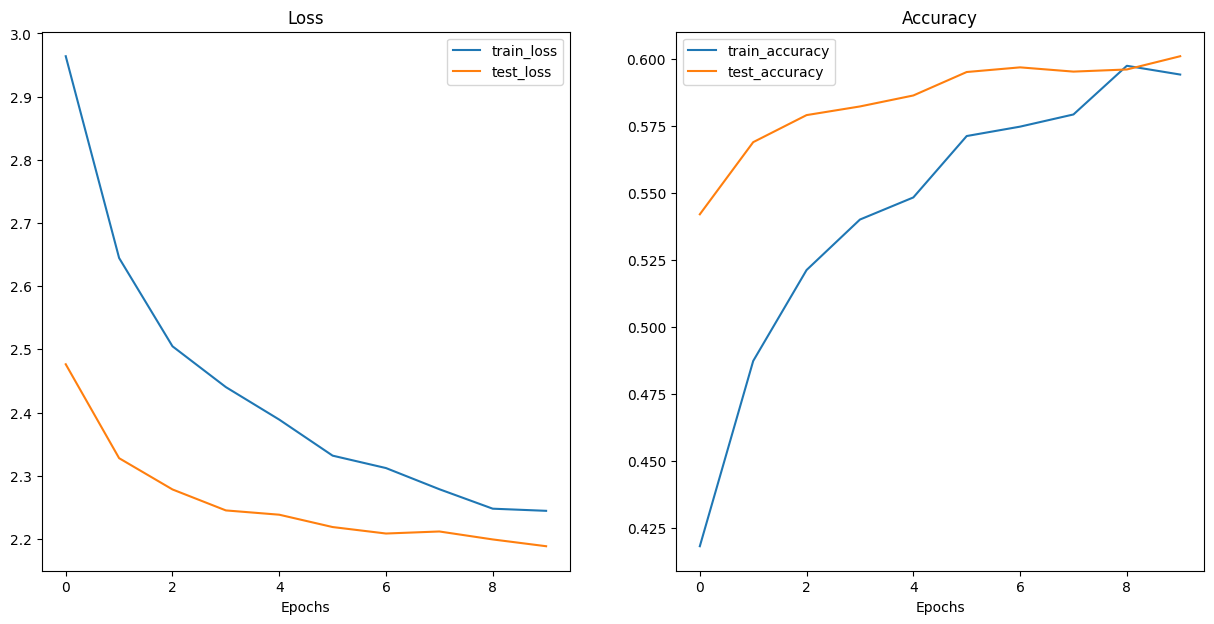

In [16]:
# Plot Effnetb2 Curves
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(len(effnetb2_results["train_loss"])), effnetb2_results["train_loss"], label="train_loss")
plt.plot(range(len(effnetb2_results["train_loss"])),  effnetb2_results["test_loss"], label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(effnetb2_results["train_loss"])), effnetb2_results["train_acc"], label="train_accuracy")
plt.plot(range(len(effnetb2_results["train_loss"])), effnetb2_results["test_acc"], label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [19]:
# Save The Model File To Models Folder
os.mkdir('models')
torch.save(obj=effnetb2.state_dict(),
          f="models/effnetb2.pth")

In [20]:
# Inspect The Size Of The Model To Compare It With Other Model Later
effnetb2_size = round(Path("models/effnetb2.pth").stat().st_size / (1024 * 1024),2)
print("effnetb2 features extractor model size is",effnetb2_size,"megabytes")

effnetb2 features extractor model size is 30.35 megabytes


In [21]:
# Inspect The Number Of Parameters Of The Model To Compare It With Other Model Later
effnetb2_total_params = sum(torch.numel(params) for params in effnetb2.parameters())
effnetb2_total_params

7843303

In [22]:
# Create a Dict With Effnetb2 Stats
effnetb2_stats = {'test_loss':effnetb2_results['test_loss'][-1],
                  'test_acc':effnetb2_results['test_acc'][-1],
                  'size':effnetb2_size,
                  'num_params':effnetb2_total_params,
                  }
effnetb2_stats

{'test_loss': 2.188405479811415,
 'test_acc': 0.6009615384615384,
 'size': 30.35,
 'num_params': 7843303}

# 3 EffNetB3 Model

## 3.1
Make a Function To Make Model And Freeze All Trainable Parameters Except Classifier Head

In [46]:
def create_effnetb3(num_classes: int = 101):
  weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b3(weights=weights).to(device)

  for params in model.parameters():
    params.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1536, out_features=num_classes, bias=True))
  return model,transforms

effnetb3,effnetb3_transforms = create_effnetb3(num_classes=101)
effnetb3_transforms

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [47]:
summary(effnetb3, input_size=(1, 3, 224, 224),col_names=['input_size','output_size','num_params','trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 2

## 3.2
Get The Data And Make A Data Loaders For EffNetB3 Model

In [48]:
# First We Will Make Data Augmentation Transform for Training Data To Eliminate Overfitting
train_transforms_effnetb3 = torchvision.transforms.Compose([ torchvision.transforms.TrivialAugmentWide(),
                                             effnetb3_transforms])
# We Will Load Food101 Dataset Using Pytorch
train_data_effnetb3 = torchvision.datasets.Food101(root="data", # Passing Root Directory
                             split='train', # Passing Train Split
                             transform=train_transforms_effnetb3, # Passing Train Transform
                             download=True)


test_data_effnetb3 = torchvision.datasets.Food101(root="data", # Passing Root Directory
                             split='test', # Passing Test Split
                             transform=effnetb3_transforms, # Passing Test Normal Transform
                             download=True)

In [49]:
class_names[:10] # Same As Effnetb2 So We Don't Need To Extract It Again

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [50]:
# We will Match Effnetb2 Model Of The Data Reduction Size

train_data_effnetb3_20_percent,_ = split_dataset(dataset=train_data_effnetb3,split_size=.2)
test_data_effnetb3_20_percent,_ = split_dataset(dataset=test_data_effnetb3,split_size=.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


In [52]:
# Create The Data Loader
batch_size = 32 # We Will Keep Constant Batch Size 32 In The Whole Notebook
num_workers=os.cpu_count() # Num Workers Equal Two

train_dataloader_effnetb3_20_percent = torch.utils.data.DataLoader(dataset=train_data_effnetb3_20_percent,
                                                                   batch_size=batch_size,
                                                                   shuffle=True,
                                                                   num_workers=num_workers
                                                                   )


test_dataloader_effnetb3_20_percent = torch.utils.data.DataLoader(dataset=test_data_effnetb3_20_percent,
                                                                 batch_size=batch_size,
                                                                 shuffle=False,
                                                                 num_workers=num_workers)

## 3.3 Train EffNetB3 Model

In [54]:
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # Label Smoothing Is Regularization To Reduce Overfitting
optimizer = torch.optim.Adam(params=effnetb3.parameters(),lr=0.001)

effnetb3_results = train(model=effnetb3,train_dataloader=train_dataloader_effnetb3_20_percent,test_dataloader=test_dataloader_effnetb3_20_percent,optimizer=optimizer,loss_fn=loss,device=device,epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: train_loss=3.4131, train_acc=0.3366, test_loss=2.6430, test_acc=0.5256
Epoch 2: train_loss=2.7565, train_acc=0.4677, test_loss=2.3703, test_acc=0.5656
Epoch 3: train_loss=2.5435, train_acc=0.5144, test_loss=2.2652, test_acc=0.5824
Epoch 4: train_loss=2.4452, train_acc=0.5397, test_loss=2.1844, test_acc=0.6092
Epoch 5: train_loss=2.3747, train_acc=0.5592, test_loss=2.1645, test_acc=0.6037
Epoch 6: train_loss=2.3132, train_acc=0.5760, test_loss=2.1528, test_acc=0.6037
Epoch 7: train_loss=2.2767, train_acc=0.5840, test_loss=2.1199, test_acc=0.6273
Epoch 8: train_loss=2.2351, train_acc=0.5977, test_loss=2.1167, test_acc=0.6215
Epoch 9: train_loss=2.2053, train_acc=0.6081, test_loss=2.1090, test_acc=0.6229
Epoch 10: train_loss=2.1978, train_acc=0.6077, test_loss=2.1129, test_acc=0.6226


## 3.4 Evaluate EffNetB3

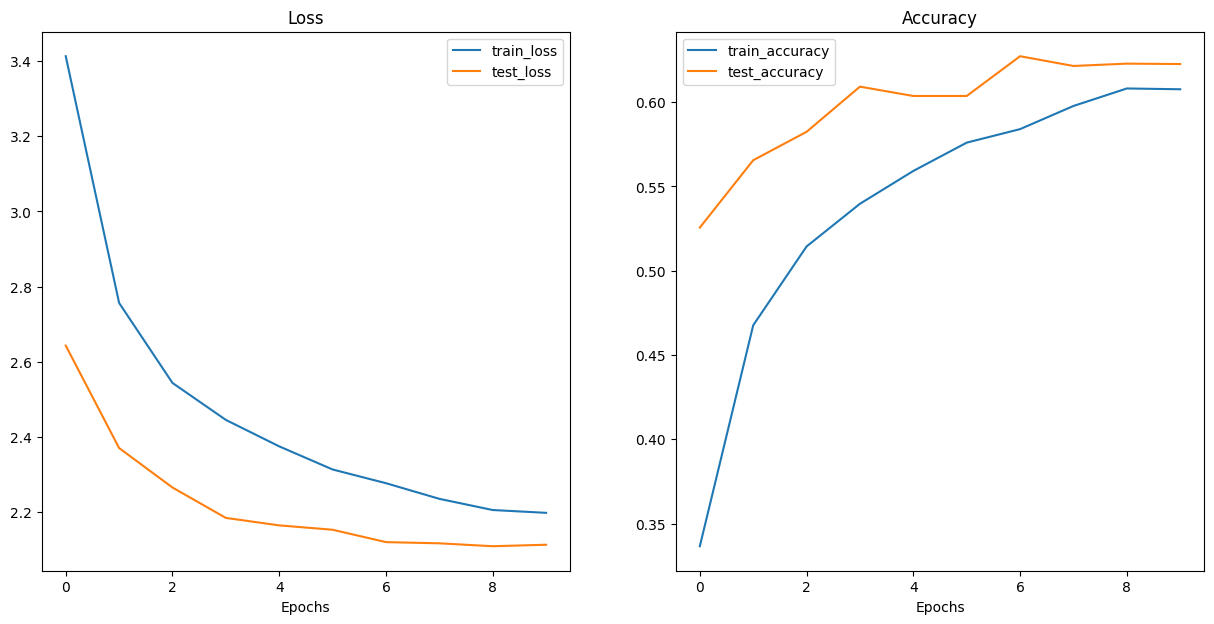

In [55]:
# Plot Effnetb2 Curves
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(len(effnetb3_results["train_loss"])), effnetb3_results["train_loss"], label="train_loss")
plt.plot(range(len(effnetb3_results["train_loss"])),  effnetb3_results["test_loss"], label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(effnetb3_results["train_loss"])), effnetb3_results["train_acc"], label="train_accuracy")
plt.plot(range(len(effnetb3_results["train_loss"])), effnetb3_results["test_acc"], label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [56]:
# Save The Model File To Models Folder
torch.save(obj=effnetb3.state_dict(),
          f="models/effnetb3.pth")

In [57]:
# Inspect The Size Of The Model To Compare It With effnetb2
effnetb3_size = round(Path("models/effnetb3.pth").stat().st_size / (1024 * 1024),2)
print("vit features extractor model size is",effnetb3_size,"megabytes")

vit features extractor model size is 41.92 megabytes


In [58]:
# Inspect The Number Of Parameters Of The Model To Compare It With effnetb2
effnetb3_total_params = sum(torch.numel(params) for params in effnetb3.parameters())
effnetb3_total_params

10851469

In [59]:
# Create a Dict With Effnetb2 Stats
effnetb3_stats = {'test_loss':effnetb3_results['test_loss'][-1],
                  'test_acc':effnetb3_results['test_acc'][-1],
                  'size':effnetb3_size,
                  'num_params':effnetb3_total_params,
                  }
effnetb3_stats

{'test_loss': 2.1129178970674927,
 'test_acc': 0.6226113680623174,
 'size': 41.92,
 'num_params': 10851469}

# 4 Choose The Best

## 4.1 Make A Function To Predict With Our Two Trained Models
To calculate comparison cf accuracy and speed.


In [60]:
def pred_and_store(paths,
                   model,
                   transform,
                   class_names,
                   device):
  pred_list = []
  for path in tqdm(paths):
    pred_dict  = {}
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    start_time = timer()
    img = Image.open(path)
    img_tensor = transform(img).unsqueeze(dim=0).to(device)
    model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logits = model(img_tensor)
      pred_prob = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict["pred_class"] = pred_class
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time,4)
    pred_dict['correct'] = class_name == pred_class
    pred_list.append(pred_dict)

  return pred_list

In [78]:
data_dir = 'data/food-101/images'

# Get paths for all images
data_paths = list(Path(data_dir).glob("*/*.jpg"))

# Randomly select 1000 images
random.seed(42)  # Set a seed for reproducibility
test_data_paths = random.sample(data_paths, 1000)

test_data_paths[:5]

[PosixPath('data/food-101/images/seaweed_salad/2237690.jpg'),
 PosixPath('data/food-101/images/falafel/1203709.jpg'),
 PosixPath('data/food-101/images/onion_rings/1467539.jpg'),
 PosixPath('data/food-101/images/macarons/845188.jpg'),
 PosixPath('data/food-101/images/filet_mignon/2222026.jpg')]

## 4.2 Measure Real-Time Accuracy and Time Taken to Predict Using EfficientNetB2 on CPU with Test Data


In [79]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                   model = effnetb2,
                   transform=effnetb2_transforms,
                   class_names=class_names,
                   device='cpu')
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/seaweed_salad/2237690.jpg,seaweed_salad,0.2256,seaweed_salad,0.1043,True
1,data/food-101/images/falafel/1203709.jpg,falafel,0.3664,falafel,0.0911,True
2,data/food-101/images/onion_rings/1467539.jpg,onion_rings,0.5379,onion_rings,0.0898,True
3,data/food-101/images/macarons/845188.jpg,macarons,0.7260,macarons,0.0893,True
4,data/food-101/images/filet_mignon/2222026.jpg,filet_mignon,0.3997,deviled_eggs,0.0877,False


In [80]:
# Calculate Average Accuracy And Average Time Taken
print('Average Accuracy:', effnetb2_test_pred_df["correct"].value_counts(normalize=True).max())
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df["time_for_pred"].mean(),4)
print("Average Time:", effnetb2_average_time_per_pred)

Average Accuracy: 0.605
Average Time: 0.0917


## 4.3 Measure Real-Time Accuracy and Time Taken to Predict Using EffNetB3 on CPU with Test Data

In [81]:
effnetb3_test_pred_dicts = pred_and_store(paths=test_data_paths,
                   model = effnetb3,
                   transform=effnetb3_transforms,
                   class_names=class_names,
                   device='cpu')
effnetb3_test_pred_df = pd.DataFrame(effnetb3_test_pred_dicts)
effnetb3_test_pred_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/seaweed_salad/2237690.jpg,seaweed_salad,0.5455,seaweed_salad,0.2133,True
1,data/food-101/images/falafel/1203709.jpg,falafel,0.5186,falafel,0.1327,True
2,data/food-101/images/onion_rings/1467539.jpg,onion_rings,0.3282,donuts,0.1217,False
3,data/food-101/images/macarons/845188.jpg,macarons,0.4177,macarons,0.1312,True
4,data/food-101/images/filet_mignon/2222026.jpg,filet_mignon,0.1904,lobster_bisque,0.1231,False


In [83]:
# Calculate Average Accuracy And Average Time Taken
print('Average Accuracy:', effnetb3_test_pred_df["correct"].value_counts(normalize=True).max())
effnetb3_average_time_per_pred = round(effnetb3_test_pred_df["time_for_pred"].mean(),4)
print("Average Time:", effnetb3_average_time_per_pred)

Average Accuracy: 0.628
Average Time: 0.131


## 4.4 EffNetB2 Vs EffNetB3



In [84]:
# Add The Results To Stats Dict
effnetb3_stats['time_per_pred'] = effnetb3_average_time_per_pred
effnetb2_stats['time_per_pred'] = effnetb2_average_time_per_pred

In [85]:
# Add Model Names To The Dict
effnetb3_stats['model']= 'EffNetB3'
effnetb2_stats['model'] = 'EffNetB2'

In [87]:
# Concate The Two DataFrames In One
df = pd.DataFrame([effnetb3_stats,effnetb2_stats],index=['effnetb3','effnetb2'])
df

,test_loss,test_acc,size,num_params,time_per_pred,model
effnetb3,2.112918,0.622611,41.92,10851469,0.1310,EffNetB3
effnetb2,2.188405,0.600962,30.35,7843303,0.0917,EffNetB2


In [88]:
# Divide EffNetB3 Stats By EffNetB2 Stats
pd.DataFrame(data=(df.set_index("model").loc["EffNetB3"] / df.set_index("model").loc["EffNetB2"]),
             columns=["EffNetB3 to EffNetB2 ratios"]).T

,test_loss,test_acc,size,num_params,time_per_pred
EffNetB3 to EffNetB2 ratios,0.965506,1.036025,1.381219,1.383533,1.428571


Visualizing The Speed VS Performance Tradeoff

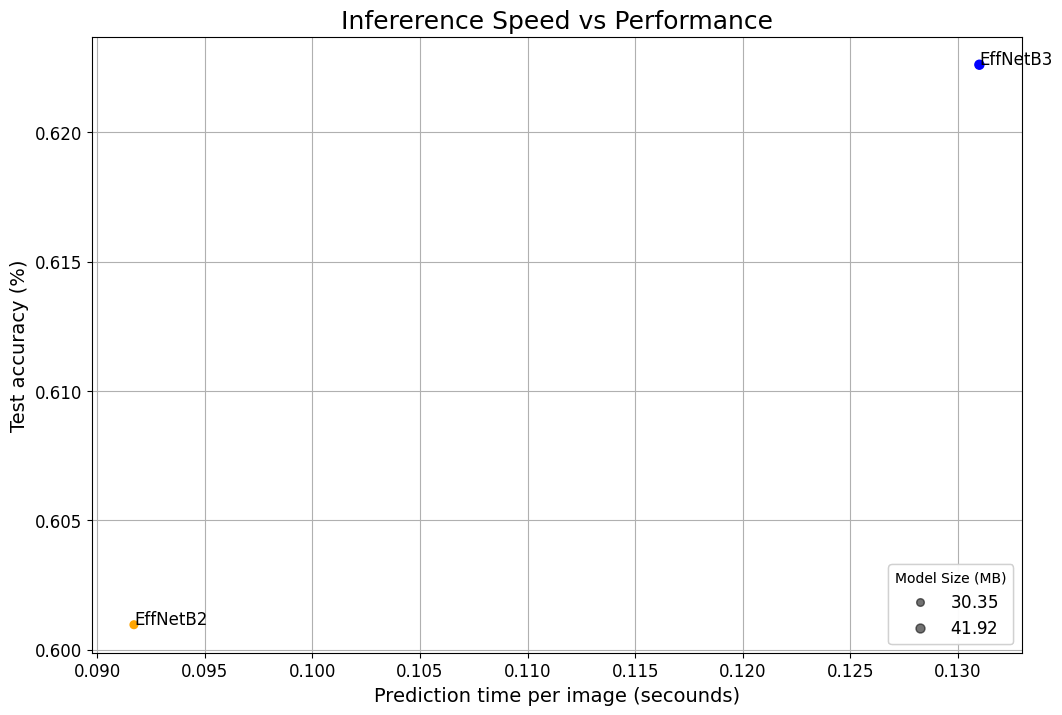

In [89]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,x='time_per_pred',y='test_acc',c=['blue','orange'],s='size')
ax.set_title("Infererence Speed vs Performance",fontsize=18)
ax.set_xlabel("Prediction time per image (secounds)",fontsize=14)
ax.set_ylabel("Test accuracy (%)",fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)
for index, row in df.iterrows():
  ax.annotate(text=row.model,xy=(row.time_per_pred,row.test_acc),size=12)
handels, labels = scatter.legend_elements(prop='sizes',alpha=0.5)
model_size_legend = ax.legend(handles=handels, labels=labels,loc='lower right',title='Model Size (MB)',fontsize=12)
fig.add_artist(model_size_legend)
plt.savefig("speed_vs_accuracy.png")

# 5 Implementing EffNetB3 To Work In HuggingFace Using Gradio SDK

To Upload The App We Must Put Every Thing Into One Directory

- FoodClassifier101/
- ├── model.pth
- ├── app.py
- ├── examples/
- │ ├── example_1.jpg
- │ ├── example_2.jpg
- │ └── example_3.jpg
- ├── model.py
- └── requirements.txt

In [90]:
# Make FoodClassifier101 Folder
foodclassifier101_path = Path("FoodClassifier101/")
foodclassifier101_path.mkdir(parents=True, exist_ok=True)

# Move Trained Model To Folder
!mv models/effnetb3.pth FoodClassifier101

In [91]:
# Create path to Food101 class names
foodclassifier101_class_names_path = foodclassifier101_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodclassifier101_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodclassifier101_class_names_path}")
    f.write("\n".join(class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to FoodClassifier101/class_names.txt


Make Model.py File

In [92]:
%%writefile FoodClassifier101/model.py

import torch
import torchvision
from torch import nn


def create_effnetb3_model(num_classes):

    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b3(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1536, out_features=num_classes),
    )

    return model, transforms

Writing FoodClassifier101/model.py


Make App.py File

In [93]:
%%writefile FoodClassifier101/app.py

import gradio as gr
import torch
import os
from model import create_effnetb3_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open('class_names.txt',"r") as f :
    class_names=  [food.strip() for food in f.readlines()]

effnetb3, effnetb3_transforms = create_effnetb3_model(num_classes=101)

effnetb3.load_state_dict(torch.load(f='effnetb3.pth',map_location=torch.device('cpu')))


def predict(img):
  start = timer()

  img_tensor = effnetb3_transforms(img).unsqueeze(dim=0)

  effnetb3.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb3(img_tensor), dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end = timer()
  pred_time = round(end - start,4)

  return pred_labels_and_probs, pred_time


title = "FoodClassifier101 🍕📸"
description = "An EfficientNetB3-based computer vision model designed to classify food images into 101 distinct categories."
example_list = [["examples/" + example] for example in os.listdir("examples")]
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    title=title,
    description=description,
    examples=example_list 
)

# Launch the app!
demo.launch()

Writing FoodClassifier101/app.py


In [94]:
%%writefile FoodClassifier101/requirements.txt
torch>=2.0.0
torchvision>=0.15.0
numpy<2
gradio>=3.0.0
anyio>=3.0.0
fsspec>=2023.1.0

Writing FoodClassifier101/requirements.txt


In [95]:
!cd FoodClassifier101 && zip -r ../FoodClassifier101.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: app.py (deflated 50%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb3.pth (deflated 8%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 18%)
